In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import numpy as np

In [2]:
%matplotlib inline

In [3]:
sns.set(rc={'figure.figsize': (11.7, 8.27)}, style="white", color_codes=True)
plt.rc('pdf', fonttype=42)  # Embed font

In [4]:
wiki_qdf = pd.read_csv('../../export/data/query-times-wiki-collsize.csv')

In [5]:
wiki_qdf.columns

Index(['name', 'iterations', 'real_time', 'cpu_time', 'time_unit',
       'bytes_per_second', 'items_per_second', 'label', 'error_occurred',
       'error_message', 'CompByesInvRate', 'CompBytesRate', 'NComp', 'NPQ',
       'NPQInvRate', 'NPQRate', 'PQByesInvRate', 'PQBytes', 'PQBytesRate'],
      dtype='object')

In [6]:
def load_qtime_collsize_df(collection, convert_units=True):
    query_df = pd.read_csv('../../export/data/query-times-{0}-collsize.csv'.format(collection))
    name_split = query_df.name.str.split('/')
    qac_impl = name_split.apply(lambda x: x[1])
    coll_size = name_split.apply(lambda x: int(x[2]))
    pqlog_nconv = name_split.apply(lambda x: int(x[3]))
    log_type = name_split.apply(lambda x: x[4])
    log_type.replace('108', 'LRLog', inplace=True)
    log_type.replace('115', 'SynthLog', inplace=True)
    
    query_df['qac_impl'] = qac_impl
    query_df['coll_size'] = coll_size
    query_df['nconv'] = pqlog_nconv
    query_df['log_type'] = log_type
    query_df['collection'] = collection
    
    query_df.drop(['name','bytes_per_second','items_per_second',
                   'label','error_occurred','error_message'], axis=1, inplace=True)
    
    if convert_units:
        if len(query_df.time_unit.unique()) > 1:
            raise ValueError('Mixed time units')
        time_unit = query_df.time_unit.unique()[0]
        if time_unit == 'ms':
            query_df.cpu_time = query_df.cpu_time/(10**3)  # ns to s
            query_df.real_time = query_df.real_time/(10**3)
        else:
            raise ValueError('Unrecognised time unit')
    
    return query_df

In [7]:
wiki_csize_df = load_qtime_collsize_df('wiki', convert_units=True)
# cweb_csize_df = load_qtime_collsize_df('cweb') # TODO: Update with Bing
# bing_csize_df = load_qtime_collsize_df('bing') # TODO: Update with CWEb

In [8]:
#combined_qtime_csize = wiki_csize_df.append(cweb_csize_df, ignore_index=True)
combined_qtime_csize = wiki_csize_df

In [9]:
combined_qtime_csize.qac_impl.unique()

array(['QueryHTrie', 'QueryMarisa', 'QueryDAWG', 'QueryIncNgTrie'],
      dtype=object)

## Plot collection size vs querying time

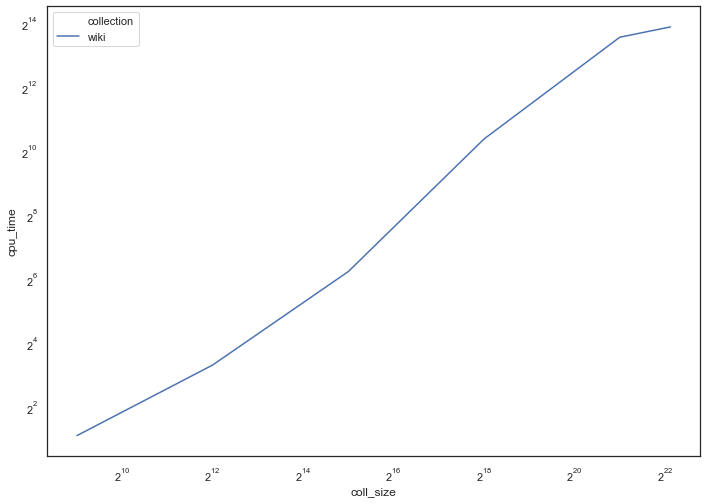

In [10]:
slice_df = combined_qtime_csize[(combined_qtime_csize.qac_impl == 'QueryIncNgTrie') & 
                                 (combined_qtime_csize.log_type == "SynthLog")]
ax = sns.lineplot(x="coll_size", y="cpu_time", hue='collection', data=slice_df)
ax.set_xscale('log', basex=2)
ax.set_yscale('log', basey=2)
plt.show()

In [11]:
wiki_csize_df.time_unit.unique()[0]

'ms'

In [12]:
1e9

1000000000.0